**Cinquième réseau** :  
- Les images sont redimensionnées à 32x32 pixels.  
- Ajustements de contraste et de luminosité.  
- Validation croisée à 10 plis.  
- Classes : ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS'].

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 3
epochs = 50
crossValidationSplit = 10

In [10]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
def charger_images_par_format_cv2(chemin):
    """
    Charge des images d'un chemin spécifique dont les noms suivent le format y_x.jpeg.
    Les images sont lues en niveaux de gris, leur taille originale est respectée, 
    et leur dimension du canal est explicitement ajoutée pour éviter toute perte d'information.
    
    Paramètres :
    chemin (str) : Chemin de base où chercher les images.
    
    Retourne :
    X (np.array) : Liste des images traitées.
    y (np.array) : Liste des labels extraits des noms des fichiers.
    input_shape (tuple) : Taille des images (hauteur, largeur, canaux).
    """
    X = []
    y = []
    dimensions = None

    # Chemin pour les images respectant le format spécifié
    chemin_images = rf'{chemin}\*_*.jpeg'

    # Parcourir toutes les images correspondant au modèle
    for fichier in glob.glob(chemin_images):
        # Lire l'image en niveaux de gris
        image = cv2.imread(fichier, cv2.IMREAD_GRAYSCALE)
        if image is not None:  # Vérifier si l'image a été correctement chargée
            # Ajouter une dimension pour le canal
            image = np.expand_dims(image, axis=-1)
            X.append(image)
            
            # Vérifier et conserver la taille de la première image
            if dimensions is None:
                hauteur, largeur = image.shape[:2]
                dimensions = (hauteur, largeur, 1)  # Ajouter explicitement le canal (gris)
            
            # Extraire le label y depuis le nom de fichier
            nom = fichier.split('\\')[-1].replace('.jpeg', '')  # Récupérer le nom sans extension
            label = int(nom.split('_')[0])  # Extraire 'y' avant le '_'
            
            y.append(label)
        else:
            print(f"Impossible de lire l'image : {fichier}")

    # Convertir X et y en tableaux numpy
    return np.array(X), np.array(y), dimensions

In [12]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [13]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5832, 32, 32, 1) échantillons d'entraînement
(32, 32, 1) input_shape
50 epochs


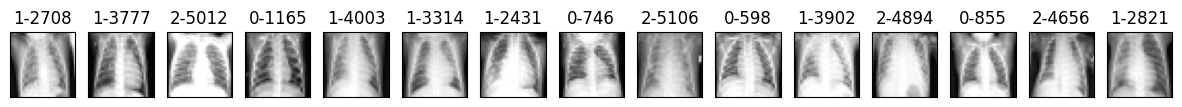

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 37ms/step - accuracy: 0.4729 - loss: 1.0620 - val_accuracy: 0.4743 - val_loss: 1.0106
Epoch 2/50
82/82 - 1s - 13ms/step - accuracy: 0.6058 - loss: 0.8587 - val_accuracy: 0.7192 - val_loss: 0.6711
Epoch 3/50
82/82 - 1s - 13ms/step - accuracy: 0.7020 - loss: 0.6721 - val_accuracy: 0.7517 - val_loss: 0.5805
Epoch 4/50
82/82 - 1s - 13ms/step - accuracy: 0.7389 - loss: 0.6153 - val_accuracy: 0.7517 - val_loss: 0.5677
Epoch 5/50
82/82 - 1s - 13ms/step - accuracy: 0.7544 - loss: 0.5789 - val_accuracy: 0.7586 - val_loss: 0.5619
Epoch 6/50
82/82 - 1s - 14ms/step - accuracy: 0.7668 - loss: 0.5545 - val_accuracy: 0.7791 - val_loss: 0.5109
Epoch 7/50
82/82 - 1s - 13ms/step - accuracy: 0.7778 - loss: 0.5368 - val_accuracy: 0.7928 - val_loss: 0.4920
Epoch 8/50
82/82 - 1s - 13ms/step - accuracy: 0.7841 - loss: 0.5160 - val_accuracy: 0.7962 - val_loss: 0.4907
Epoch 9/50
82/82 - 1s - 13ms/step - accuracy: 0.7843 - loss: 0.5044 - val_accuracy: 0.7860 - val_loss: 0.4817
Epoch

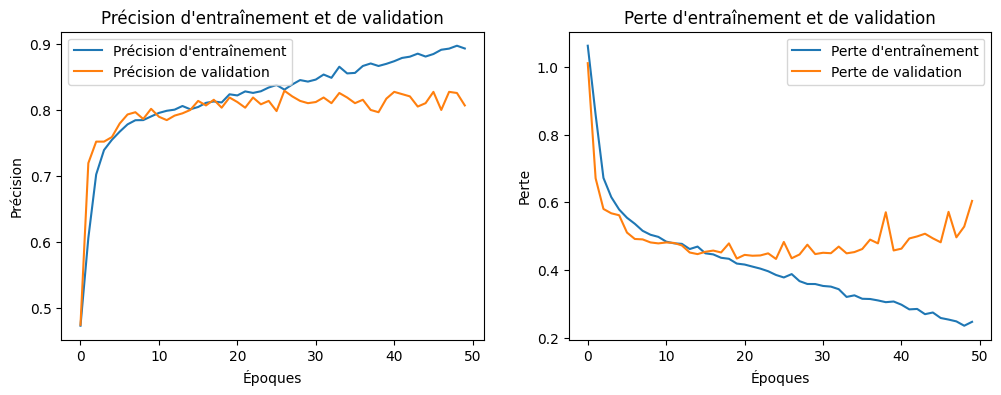

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8803 - loss: 0.4012
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 1:
perte: 0.60 précision: 0.81
AUC 0.9172
Prédictions
Counter({np.int64(1): 316, np.int64(0): 152, np.int64(2): 116}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.95      0.92      0.94       158
Pneumonia_bacteriana       0.78      0.89      0.83       277
     Pneumonia_viral       0.69      0.54      0.60       149

            accuracy                           0.81       584
           macro avg       0.81      0.78      0.79       584
        weighted avg       0.80      0.81      0.80       584

Matrice de confusion


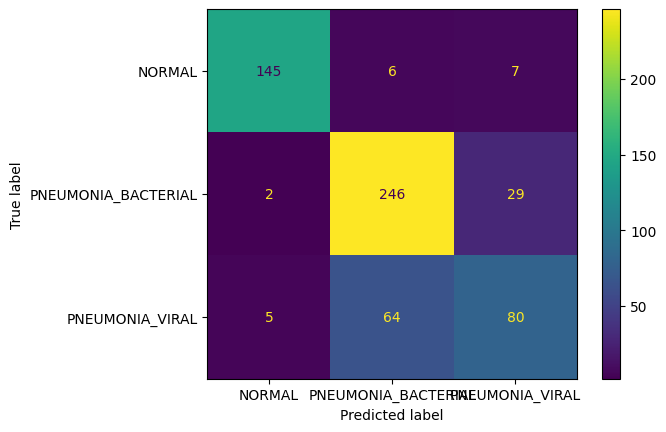

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 38ms/step - accuracy: 0.4722 - loss: 1.0619 - val_accuracy: 0.4743 - val_loss: 1.0430
Epoch 2/50
82/82 - 1s - 13ms/step - accuracy: 0.5596 - loss: 0.9438 - val_accuracy: 0.6712 - val_loss: 0.7449
Epoch 3/50
82/82 - 1s - 14ms/step - accuracy: 0.6942 - loss: 0.6983 - val_accuracy: 0.7175 - val_loss: 0.6349
Epoch 4/50
82/82 - 1s - 14ms/step - accuracy: 0.7325 - loss: 0.6179 - val_accuracy: 0.7466 - val_loss: 0.5935
Epoch 5/50
82/82 - 1s - 15ms/step - accuracy: 0.7601 - loss: 0.5754 - val_accuracy: 0.7671 - val_loss: 0.5669
Epoch 6/50
82/82 - 1s - 14ms/step - accuracy: 0.7734 - loss: 0.5401 - val_accuracy: 0.7723 - val_loss: 0.5561
Epoch 7/50
82/82 - 1s - 14ms/step - accuracy: 0.7782 - loss: 0.5246 - val_accuracy: 0.7723 - val_loss: 0.5422
Epoch 8/50
82/82 - 1s - 14ms/step - accuracy: 0.7833 - loss: 0.5139 - val_accuracy: 0.7723 - val_loss: 0.5658
Epoch 9/50
82/82 - 1s - 14ms/step - accuracy: 0.7925 - loss: 0.4969 - val_accuracy: 0.7791 - val_loss: 0.5349
Epoch

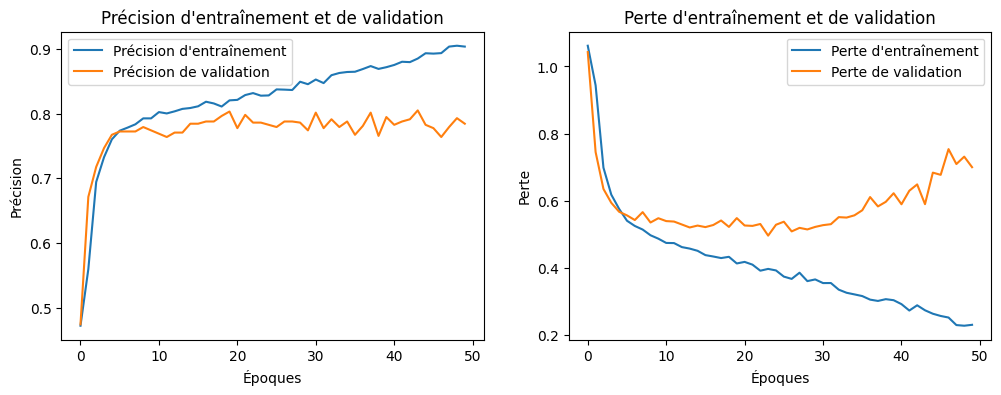

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8418 - loss: 0.5914
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 2:
perte: 0.70 précision: 0.78
AUC 0.9081
Prédictions
Counter({np.int64(1): 288, np.int64(0): 154, np.int64(2): 142}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.92      0.89      0.90       158
Pneumonia_bacteriana       0.80      0.83      0.82       277
     Pneumonia_viral       0.61      0.58      0.59       149

            accuracy                           0.78       584
           macro avg       0.77      0.77      0.77       584
        weighted avg       0.78      0.78      0.78       584

Matrice de confusion


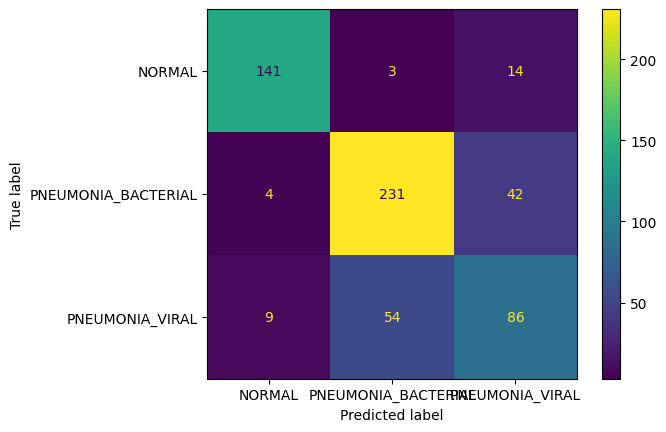

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 34ms/step - accuracy: 0.4812 - loss: 1.0515 - val_accuracy: 0.5283 - val_loss: 0.9456
Epoch 2/50
83/83 - 1s - 13ms/step - accuracy: 0.6401 - loss: 0.8110 - val_accuracy: 0.6552 - val_loss: 0.7152
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.7152 - loss: 0.6623 - val_accuracy: 0.7204 - val_loss: 0.6307
Epoch 4/50
83/83 - 1s - 14ms/step - accuracy: 0.7424 - loss: 0.6095 - val_accuracy: 0.7324 - val_loss: 0.5886
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.7580 - loss: 0.5830 - val_accuracy: 0.7530 - val_loss: 0.5466
Epoch 6/50
83/83 - 1s - 14ms/step - accuracy: 0.7720 - loss: 0.5535 - val_accuracy: 0.7513 - val_loss: 0.5498
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.7815 - loss: 0.5284 - val_accuracy: 0.7564 - val_loss: 0.5733
Epoch 8/50
83/83 - 1s - 14ms/step - accuracy: 0.7761 - loss: 0.5348 - val_accuracy: 0.7702 - val_loss: 0.5095
Epoch 9/50
83/83 - 1s - 14ms/step - accuracy: 0.7843 - loss: 0.5254 - val_accuracy: 0.7770 - val_loss: 0.5164
Epoch

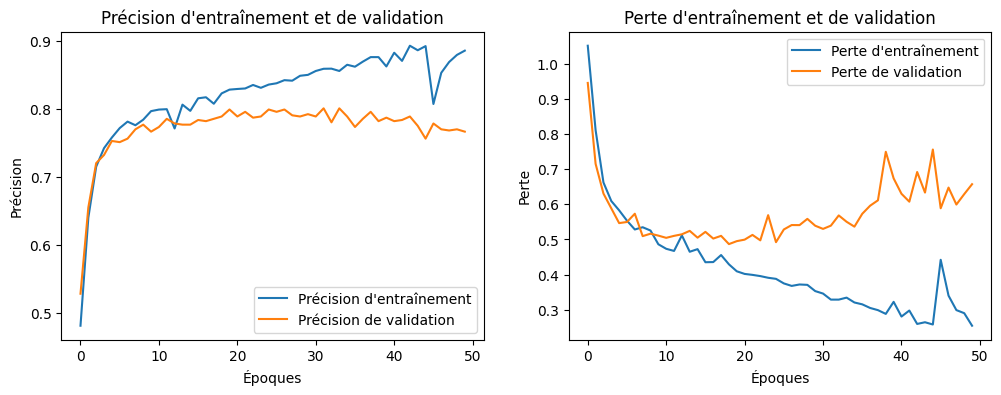

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8238 - loss: 0.5126 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 3:
perte: 0.66 précision: 0.77
AUC 0.9045
Prédictions
Counter({np.int64(1): 277, np.int64(0): 160, np.int64(2): 146}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.89      0.91      0.90       158
Pneumonia_bacteriana       0.79      0.79      0.79       277
     Pneumonia_viral       0.58      0.57      0.58       148

            accuracy                           0.77       583
           macro avg       0.76      0.76      0.76       583
        weighted avg       0.77      0.77      0.77       583

Matrice de confusion


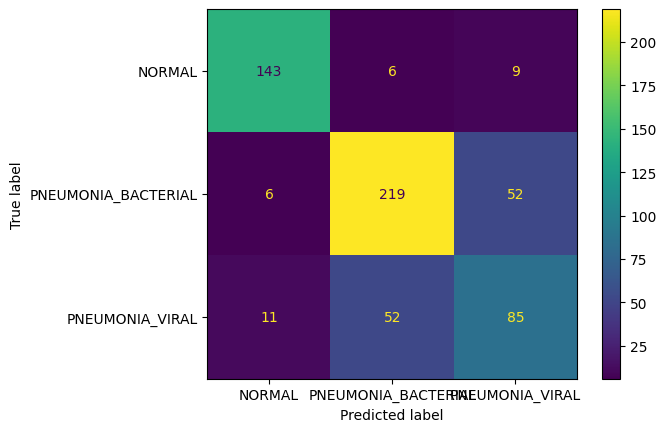

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.5001 - loss: 1.0278 - val_accuracy: 0.4889 - val_loss: 1.1123
Epoch 2/50
83/83 - 1s - 13ms/step - accuracy: 0.6352 - loss: 0.8214 - val_accuracy: 0.6638 - val_loss: 0.7193
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.7091 - loss: 0.6586 - val_accuracy: 0.7650 - val_loss: 0.5532
Epoch 4/50
83/83 - 1s - 15ms/step - accuracy: 0.7369 - loss: 0.6174 - val_accuracy: 0.7616 - val_loss: 0.5871
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.7159 - loss: 0.6668 - val_accuracy: 0.7976 - val_loss: 0.5130
Epoch 6/50
83/83 - 1s - 14ms/step - accuracy: 0.7567 - loss: 0.5758 - val_accuracy: 0.7942 - val_loss: 0.4893
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.7693 - loss: 0.5555 - val_accuracy: 0.8096 - val_loss: 0.4680
Epoch 8/50
83/83 - 1s - 14ms/step - accuracy: 0.7786 - loss: 0.5274 - val_accuracy: 0.7942 - val_loss: 0.4905
Epoch 9/50
83/83 - 1s - 14ms/step - accuracy: 0.7796 - loss: 0.5231 - val_accuracy: 0.8096 - val_loss: 0.4691
Epoch

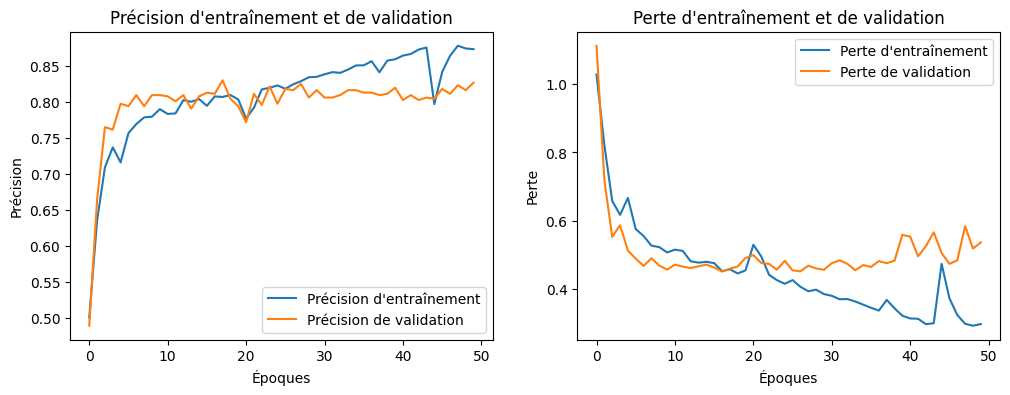

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8772 - loss: 0.4765
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 4:
perte: 0.54 précision: 0.83
AUC 0.9289
Prédictions
Counter({np.int64(1): 285, np.int64(0): 160, np.int64(2): 138}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.92      0.93      0.92       158
Pneumonia_bacteriana       0.83      0.86      0.84       277
     Pneumonia_viral       0.71      0.66      0.69       148

            accuracy                           0.83       583
           macro avg       0.82      0.82      0.82       583
        weighted avg       0.82      0.83      0.83       583

Matrice de confusion


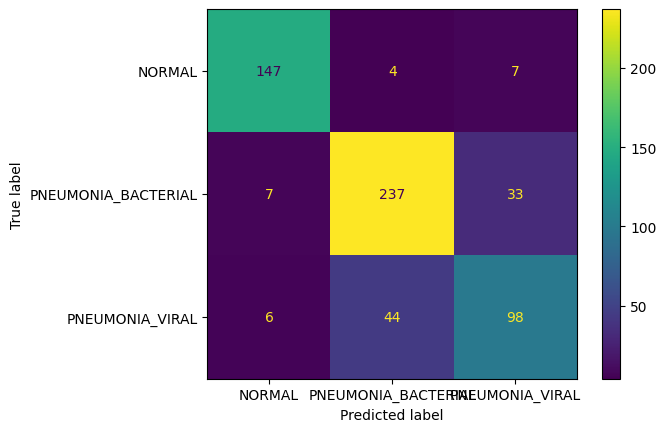

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_21 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 34ms/step - accuracy: 0.4734 - loss: 1.0598 - val_accuracy: 0.4751 - val_loss: 1.0468
Epoch 2/50
83/83 - 1s - 13ms/step - accuracy: 0.5388 - loss: 0.9562 - val_accuracy: 0.6226 - val_loss: 0.8063
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.6828 - loss: 0.7138 - val_accuracy: 0.6775 - val_loss: 0.6891
Epoch 4/50
83/83 - 1s - 14ms/step - accuracy: 0.6973 - loss: 0.6912 - val_accuracy: 0.7547 - val_loss: 0.5891
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7335 - loss: 0.6303 - val_accuracy: 0.7616 - val_loss: 0.5606
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.7489 - loss: 0.6013 - val_accuracy: 0.7633 - val_loss: 0.5633
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7539 - loss: 0.5883 - val_accuracy: 0.7650 - val_loss: 0.5481
Epoch 8/50
83/83 - 1s - 15ms/step - accuracy: 0.7661 - loss: 0.5661 - val_accuracy: 0.7787 - val_loss: 0.5170
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7691 - loss: 0.5549 - val_accuracy: 0.7873 - val_loss: 0.5066
Epoch

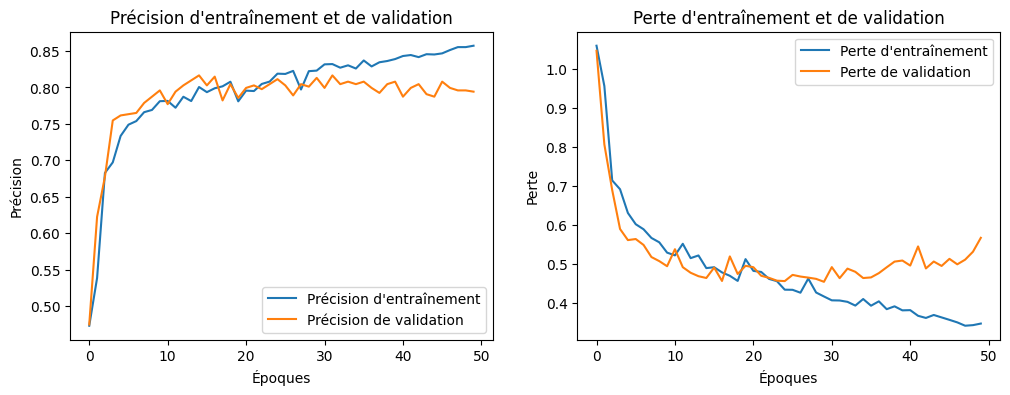

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8727 - loss: 0.4555
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 5:
perte: 0.57 précision: 0.79
AUC 0.9130
Prédictions
Counter({np.int64(1): 330, np.int64(0): 154, np.int64(2): 99}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.94      0.92      0.93       158
Pneumonia_bacteriana       0.75      0.90      0.82       277
     Pneumonia_viral       0.70      0.47      0.56       148

            accuracy                           0.79       583
           macro avg       0.80      0.76      0.77       583
        weighted avg       0.79      0.79      0.78       583

Matrice de confusion


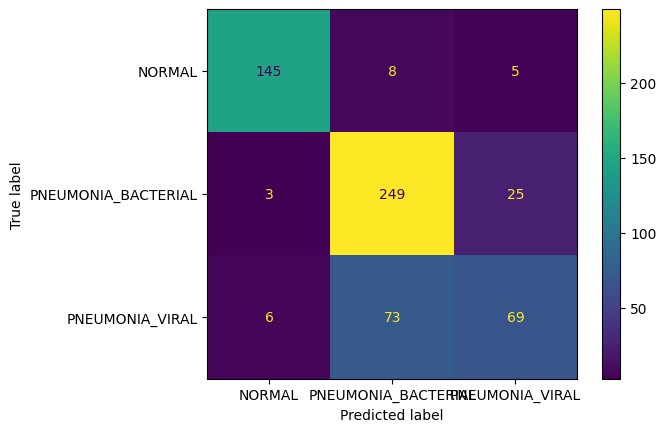

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_22 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 41ms/step - accuracy: 0.4704 - loss: 1.0539 - val_accuracy: 0.4768 - val_loss: 1.0869
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.6045 - loss: 0.8821 - val_accuracy: 0.6998 - val_loss: 0.6855
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.7140 - loss: 0.6759 - val_accuracy: 0.7444 - val_loss: 0.6309
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7321 - loss: 0.6238 - val_accuracy: 0.6467 - val_loss: 0.8086
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7268 - loss: 0.6415 - val_accuracy: 0.7650 - val_loss: 0.5483
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.7685 - loss: 0.5514 - val_accuracy: 0.7770 - val_loss: 0.5482
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7721 - loss: 0.5392 - val_accuracy: 0.7702 - val_loss: 0.5372
Epoch 8/50
83/83 - 1s - 14ms/step - accuracy: 0.7788 - loss: 0.5231 - val_accuracy: 0.7410 - val_loss: 0.6239
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.7384 - loss: 0.6038 - val_accuracy: 0.7702 - val_loss: 0.5401
Epoch

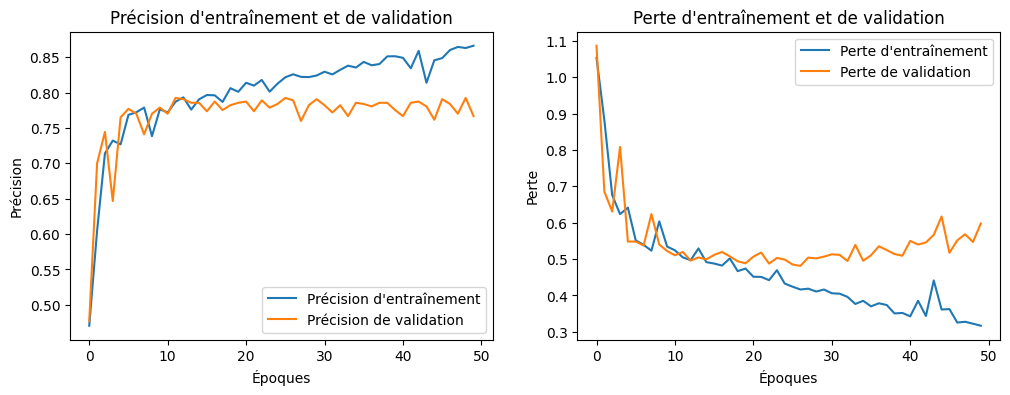

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8186 - loss: 0.4863 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 6:
perte: 0.60 précision: 0.77
AUC 0.8997
Prédictions
Counter({np.int64(1): 240, np.int64(2): 190, np.int64(0): 153}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.91      0.92       157
Pneumonia_bacteriana       0.82      0.71      0.76       278
     Pneumonia_viral       0.56      0.72      0.63       148

            accuracy                           0.77       583
           macro avg       0.77      0.78      0.77       583
        weighted avg       0.79      0.77      0.77       583

Matrice de confusion


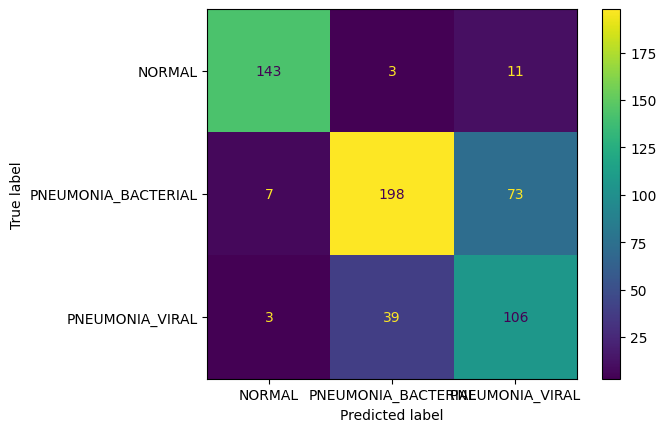

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_23 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.4818 - loss: 1.0513 - val_accuracy: 0.4768 - val_loss: 0.9964
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.6176 - loss: 0.8569 - val_accuracy: 0.6261 - val_loss: 0.7953
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.7102 - loss: 0.6583 - val_accuracy: 0.6810 - val_loss: 0.7010
Epoch 4/50
83/83 - 1s - 17ms/step - accuracy: 0.7420 - loss: 0.6080 - val_accuracy: 0.7513 - val_loss: 0.6513
Epoch 5/50
83/83 - 1s - 17ms/step - accuracy: 0.7659 - loss: 0.5661 - val_accuracy: 0.7410 - val_loss: 0.6003
Epoch 6/50
83/83 - 2s - 19ms/step - accuracy: 0.7760 - loss: 0.5438 - val_accuracy: 0.7770 - val_loss: 0.5304
Epoch 7/50
83/83 - 2s - 21ms/step - accuracy: 0.7868 - loss: 0.5153 - val_accuracy: 0.7770 - val_loss: 0.5495
Epoch 8/50
83/83 - 1s - 18ms/step - accuracy: 0.7895 - loss: 0.5077 - val_accuracy: 0.7684 - val_loss: 0.5669
Epoch 9/50
83/83 - 2s - 19ms/step - accuracy: 0.7988 - loss: 0.4876 - val_accuracy: 0.7581 - val_loss: 0.5495
Epoch

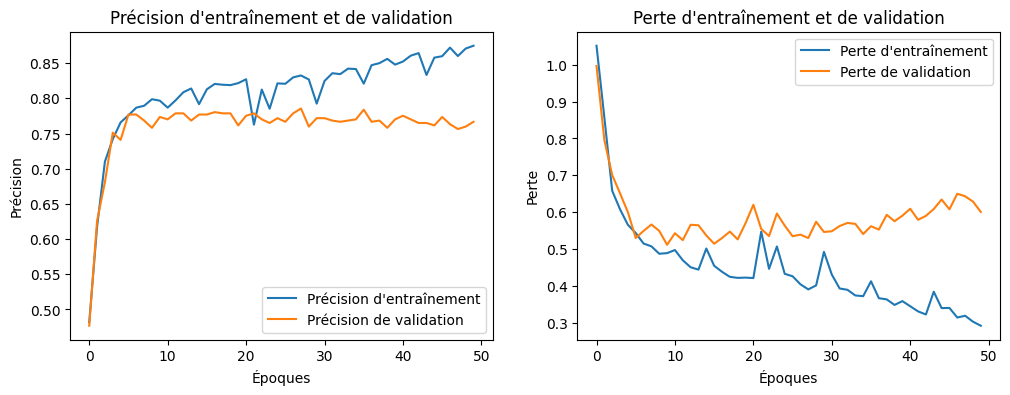

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8445 - loss: 0.4363
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 7:
perte: 0.60 précision: 0.77
AUC 0.9060
Prédictions
Counter({np.int64(1): 302, np.int64(0): 162, np.int64(2): 119}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.88      0.91      0.90       157
Pneumonia_bacteriana       0.77      0.83      0.80       278
     Pneumonia_viral       0.61      0.49      0.54       148

            accuracy                           0.77       583
           macro avg       0.75      0.74      0.75       583
        weighted avg       0.76      0.77      0.76       583

Matrice de confusion


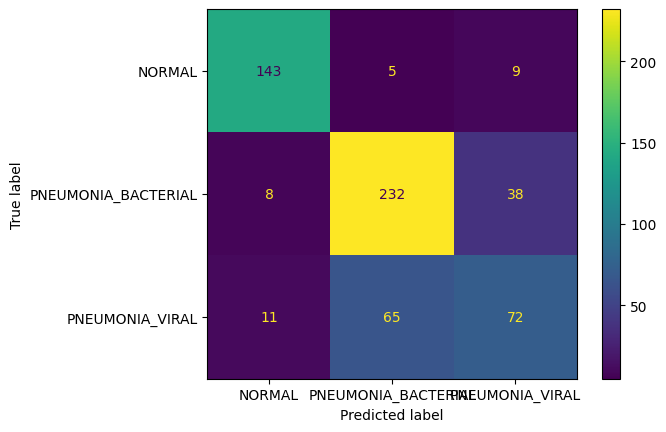

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_24 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 4s - 44ms/step - accuracy: 0.4824 - loss: 1.0502 - val_accuracy: 0.6432 - val_loss: 0.9705
Epoch 2/50
83/83 - 1s - 17ms/step - accuracy: 0.6232 - loss: 0.8526 - val_accuracy: 0.6878 - val_loss: 0.7137
Epoch 3/50
83/83 - 1s - 17ms/step - accuracy: 0.6862 - loss: 0.7090 - val_accuracy: 0.7238 - val_loss: 0.6176
Epoch 4/50
83/83 - 2s - 19ms/step - accuracy: 0.7066 - loss: 0.6555 - val_accuracy: 0.7444 - val_loss: 0.5710
Epoch 5/50
83/83 - 1s - 17ms/step - accuracy: 0.7356 - loss: 0.6154 - val_accuracy: 0.7770 - val_loss: 0.5238
Epoch 6/50
83/83 - 2s - 18ms/step - accuracy: 0.7440 - loss: 0.6046 - val_accuracy: 0.7684 - val_loss: 0.5570
Epoch 7/50
83/83 - 1s - 17ms/step - accuracy: 0.7655 - loss: 0.5615 - val_accuracy: 0.8045 - val_loss: 0.4922
Epoch 8/50
83/83 - 2s - 19ms/step - accuracy: 0.7653 - loss: 0.5561 - val_accuracy: 0.8027 - val_loss: 0.5054
Epoch 9/50
83/83 - 1s - 17ms/step - accuracy: 0.7801 - loss: 0.5319 - val_accuracy: 0.7907 - val_loss: 0.5042
Epoch

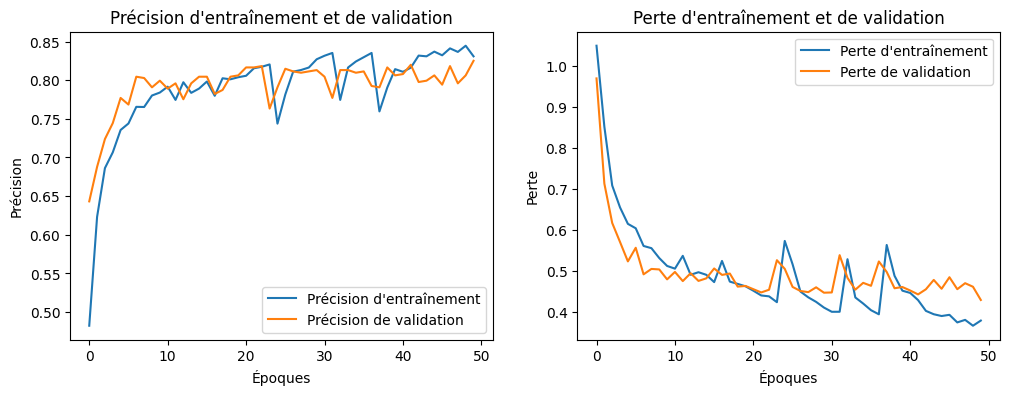

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8839 - loss: 0.3115
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 8:
perte: 0.43 précision: 0.83
AUC 0.9301
Prédictions
Counter({np.int64(1): 298, np.int64(0): 157, np.int64(2): 128}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.93      0.93       157
Pneumonia_bacteriana       0.82      0.88      0.85       277
     Pneumonia_viral       0.70      0.60      0.65       149

            accuracy                           0.83       583
           macro avg       0.82      0.81      0.81       583
        weighted avg       0.82      0.83      0.82       583

Matrice de confusion


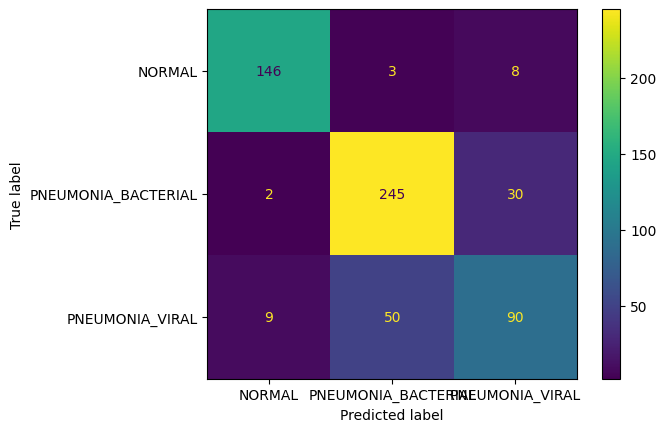

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_25 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 4s - 42ms/step - accuracy: 0.4700 - loss: 1.0585 - val_accuracy: 0.4751 - val_loss: 0.9951
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.5994 - loss: 0.8720 - val_accuracy: 0.6724 - val_loss: 0.7256
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.6965 - loss: 0.6845 - val_accuracy: 0.7290 - val_loss: 0.6000
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.7289 - loss: 0.6401 - val_accuracy: 0.7547 - val_loss: 0.5696
Epoch 5/50
83/83 - 1s - 15ms/step - accuracy: 0.7403 - loss: 0.6107 - val_accuracy: 0.7684 - val_loss: 0.5601
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.7641 - loss: 0.5696 - val_accuracy: 0.7616 - val_loss: 0.5555
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.7609 - loss: 0.5628 - val_accuracy: 0.7547 - val_loss: 0.5360
Epoch 8/50
83/83 - 1s - 17ms/step - accuracy: 0.7685 - loss: 0.5417 - val_accuracy: 0.7702 - val_loss: 0.5298
Epoch 9/50
83/83 - 1s - 17ms/step - accuracy: 0.7822 - loss: 0.5206 - val_accuracy: 0.7804 - val_loss: 0.5084
Epoch

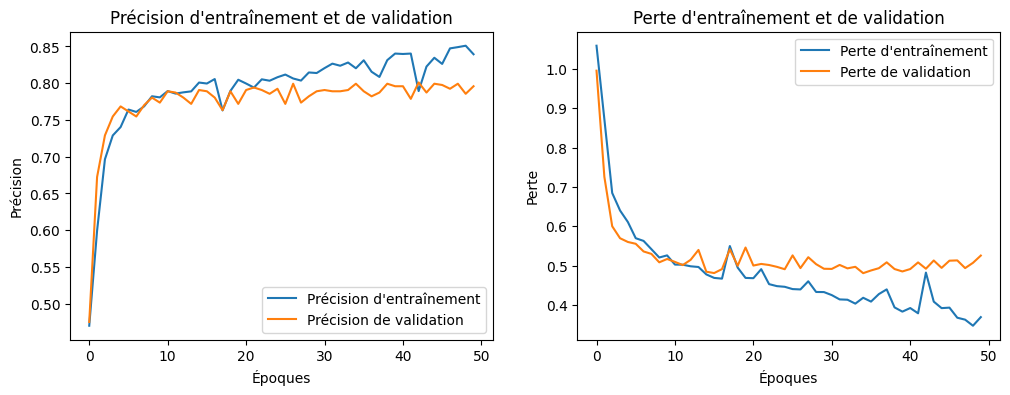

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8628 - loss: 0.3837 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 9:
perte: 0.53 précision: 0.80
AUC 0.9187
Prédictions
Counter({np.int64(1): 282, np.int64(0): 166, np.int64(2): 135}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.89      0.94      0.91       157
Pneumonia_bacteriana       0.82      0.83      0.82       277
     Pneumonia_viral       0.64      0.58      0.61       149

            accuracy                           0.80       583
           macro avg       0.78      0.78      0.78       583
        weighted avg       0.79      0.80      0.79       583

Matrice de confusion


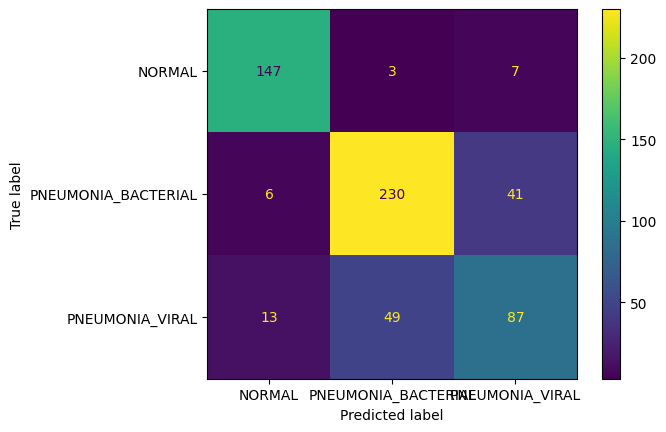

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_26 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 40ms/step - accuracy: 0.4694 - loss: 1.0677 - val_accuracy: 0.4751 - val_loss: 1.0446
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.5733 - loss: 0.9071 - val_accuracy: 0.6604 - val_loss: 0.7428
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.6910 - loss: 0.6945 - val_accuracy: 0.6621 - val_loss: 0.7197
Epoch 4/50
83/83 - 1s - 17ms/step - accuracy: 0.7276 - loss: 0.6398 - val_accuracy: 0.7410 - val_loss: 0.5825
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.7586 - loss: 0.5742 - val_accuracy: 0.7719 - val_loss: 0.5442
Epoch 6/50
83/83 - 1s - 17ms/step - accuracy: 0.7685 - loss: 0.5600 - val_accuracy: 0.7770 - val_loss: 0.5273
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.7841 - loss: 0.5277 - val_accuracy: 0.7616 - val_loss: 0.5496
Epoch 8/50
83/83 - 1s - 17ms/step - accuracy: 0.7845 - loss: 0.5190 - val_accuracy: 0.7633 - val_loss: 0.5659
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.7895 - loss: 0.5090 - val_accuracy: 0.7856 - val_loss: 0.5125
Epoch

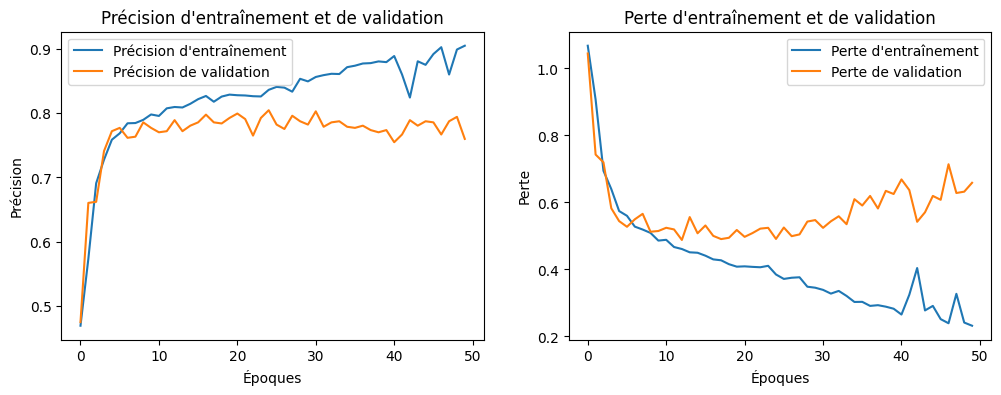

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8082 - loss: 0.5758
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 10:
perte: 0.66 précision: 0.76
AUC 0.8948
Prédictions
Counter({np.int64(1): 323, np.int64(0): 137, np.int64(2): 123}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.95      0.83      0.88       157
Pneumonia_bacteriana       0.74      0.87      0.80       277
     Pneumonia_viral       0.59      0.49      0.54       149

            accuracy                           0.76       583
           macro avg       0.76      0.73      0.74       583
        weighted avg       0.76      0.76      0.76       583

Matrice de confusion


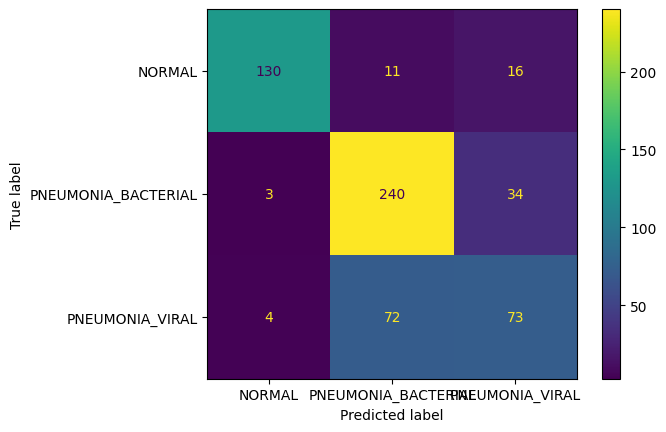

Le meilleur modèle a été sauvegardé avec un ROC de: 0.930108913950284
Fin de l'entraînement
Résultats ROC:
0.9171505420440154

0.9081122749067942

0.9045199140305747

0.9289250229071094

0.9129794124387517

0.8997201628407255

0.9059899920023776

0.930108913950284

0.9187332163275969

0.8948361280109293

Tableau enregistré avec succès dans 'resultatsROC_2_3.txt'


In [15]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = charger_images_par_format_cv2(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    #90% train | 10% test
    for train_index, test_index in kf.split(X, y):
        # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)
        
        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia_bacteriana', 'Pneumonia_viral']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA_BACTERIAL','PNEUMONIA_VIRAL']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_2_3.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "resultatsROC_2_3.txt")

if __name__ == '__main__':
    path_save_32x32=r"..\data\processed\images_32x32_mod"
    main(path_save_32x32)
